In [7]:
import numpy
from custom_gates import RiSwapGate
import weylchamber
from qiskit import QuantumCircuit
from itertools import cycle
from qiskit.quantum_info import Operator
from qiskit.circuit import Parameter
import numpy as np

In [8]:
class TemplateCircuit:
    def __init__(
        self,
        n_qubits=2,
        base_gate_class=[RiSwapGate],
        gate_2q_params=[1 / 2],
        edge_params=[(0, 1)],
        trotter=False,
        trotter_variant=False
    ):
        """Initalizes a qiskit.quantumCircuit object with unbound 1Q gate parameters
        Args:
            n_qubits: size of target unitary,
            base_gate_class: Gate class of 2Q gate,
            gate_2q_params: List of params to define template gate cycle sequence
            edge_params: List of edges to define topology cycle sequence
            trotter: if true, only use gate_2q_params[0], override cycle length and edge_params, each 1Q gate share parameters per qubit row
        """
        self.hash = (
            str(n_qubits)
            + str(base_gate_class)
            + str(gate_2q_params)
            + str(edge_params)
            + str(trotter)
        )

        if n_qubits != 2 and trotter:
            raise NotImplementedError
        self.n_qubits = n_qubits
        self.trotter = trotter
        self.circuit = QuantumCircuit(n_qubits)
        self.gate_2q_base = base_gate_class

        self.cycles = 0

        if self.trotter:
            if self.gate_2q_base != [RiSwapGate]:
                raise NotImplementedError
            
            self.gate_2q_base = cycle(base_gate_class)
            # fixed param value, take first element
            self.gate_2q_params = cycle(gate_2q_params[:1])
            # override edges
            self.gate_2q_edges = cycle([(0, 1)])
            # fixed length, equals a full gate
            self.cycle_length = 1
        else:
            self.gate_2q_base = cycle(base_gate_class)
            self.gate_2q_params = cycle(gate_2q_params)
            self.gate_2q_edges = cycle(edge_params)
            self.cycle_length = max(len(gate_2q_params), len(edge_params))

        self.gen_1q_params = self._param_iter()

    # def __str__(self):
    #     s = ""
    #     for param in self.gate_2q_params:
    #         s += self.gate_2q_base.latex_string(param)
    #     return s

    def build(self, n_repetitions):
        self._reset()
        if self.trotter:
            #n_repetitions = int(1 / next(self.gate_2q_params))
            pass
        for _ in range(n_repetitions - 1):
            self._build_cycle()

    def _reset(self):
        """Return template to a single cycle"""
        self.cycles = 0
        self.circuit = QuantumCircuit(self.n_qubits)
        self._build_cycle(initial=True)

    def initial_guess(self):
        """returns a np array of random values for each parameter"""
        return np.random.random(len(self.circuit.parameters)) * 2 * np.pi

    def assign_Xk(self, Xk):
        
        return self.circuit.assign_parameters(
                {parameter: i for parameter, i in zip(self.circuit.parameters, Xk)}
            )
    def eval(self, Xk):
        """returns an Operator after binding parameter array to template"""
        return Operator(self.assign_Xk(Xk)).data

    def _param_iter(self):
        index = 0
        while True:
            # Check if Parameter already created, then return reference to that variable
            def _filter_param(param):
                return param.name == f"P{index}"

            res = list(filter(_filter_param, self.circuit.parameters))
            if len(res) == 0:
                yield Parameter(f"P{index}")
            else:
                yield res[0]
            index += 1
            if self.trotter:
                index %= 3 * self.n_qubits

    def _build_cycle(self, initial=False):
        """Extends tempalte by one full cycle"""
        if initial:
            # before build by extend, add first pair of 1Qs
            for qubit in range(self.n_qubits):
                self.circuit.u(*[next(self.gen_1q_params) for _ in range(3)], qubit)
        for _ in range(self.cycle_length):
            edge = next(self.gate_2q_edges)
            self.circuit.append(next(self.gate_2q_base)(next(self.gate_2q_params)), edge)
            for qubit in edge:
                self.circuit.u(*[next(self.gen_1q_params) for _ in range(3)], qubit)
        self.cycles += 1


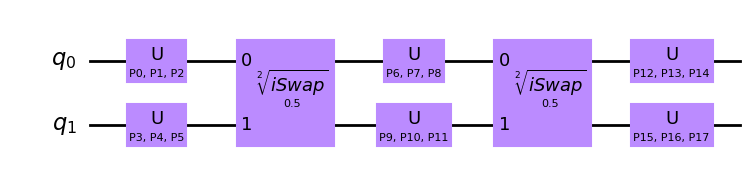

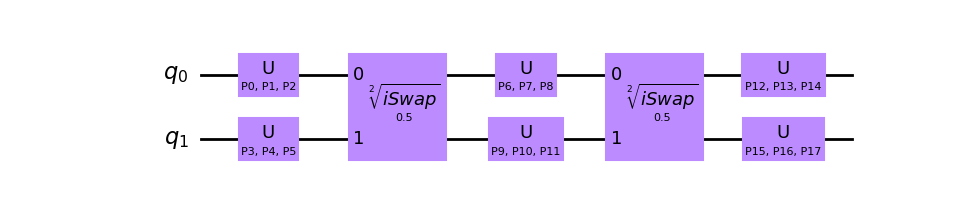

In [9]:
qc = TemplateCircuit(gate_2q_params=[1/2])
qc.build(2)
qc.circuit.draw(output='mpl')

In [10]:
def sample(param=1/2, length=2, N=4000):
    #want to characterize the vectors from 2,2, template
    list_coordinates = []
    for _ in range(N):
        qc = TemplateCircuit(gate_2q_params=[param])
        qc.build(length)
        Xk = qc.initial_guess()
        qc = qc.assign_Xk(Xk)
        gate = Operator(qc).data
        c1, c2, c3 = weylchamber.c1c2c3(gate)
        w.add_point(c1, c2, c3)
        list_coordinates.append((c1,c2,c3))
    
    return list_coordinates

In [11]:
import ipympl
%matplotlib widget

volume inside points is:  0.020527139624513985


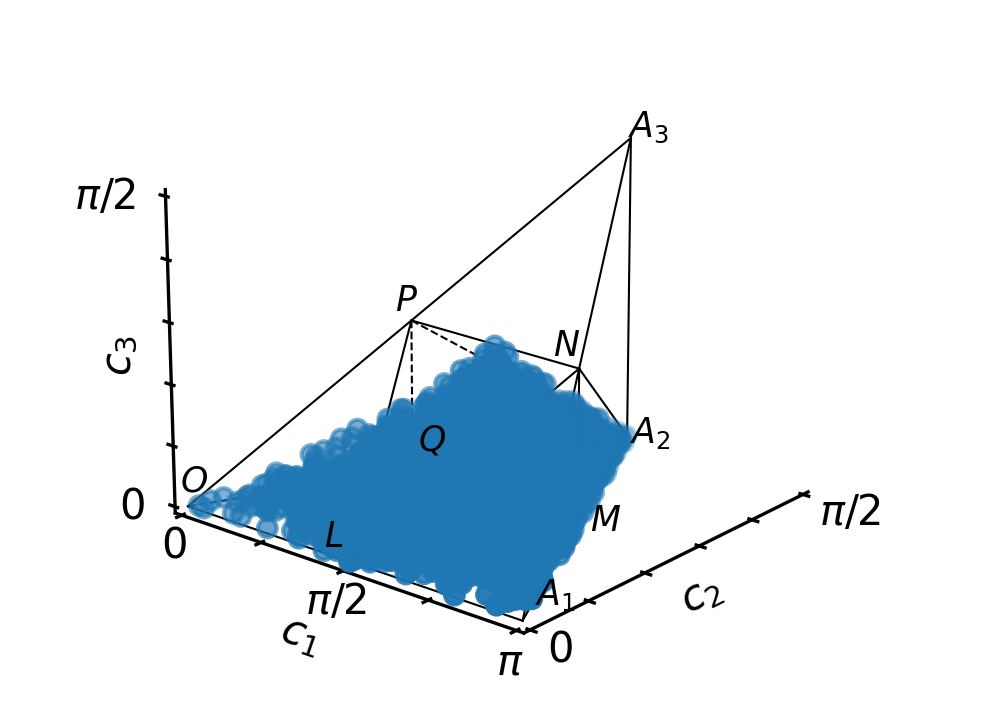

In [12]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/2, length=2)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

volume inside points is:  0.0302372147819312


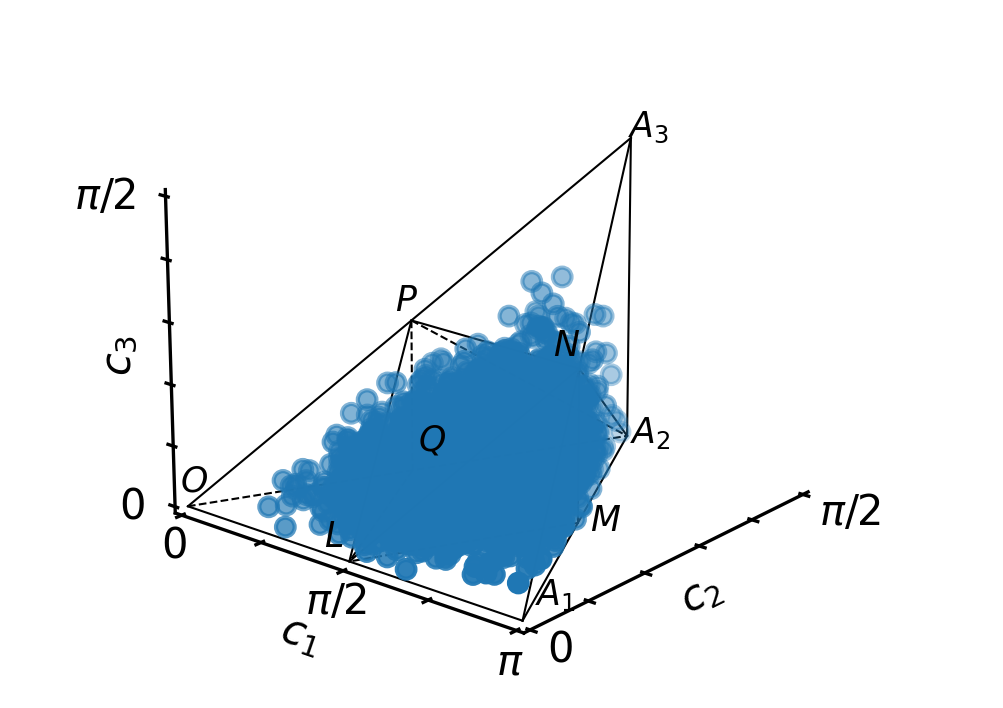

In [16]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/2, length=3)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

volume inside points is:  0.014897507379858085


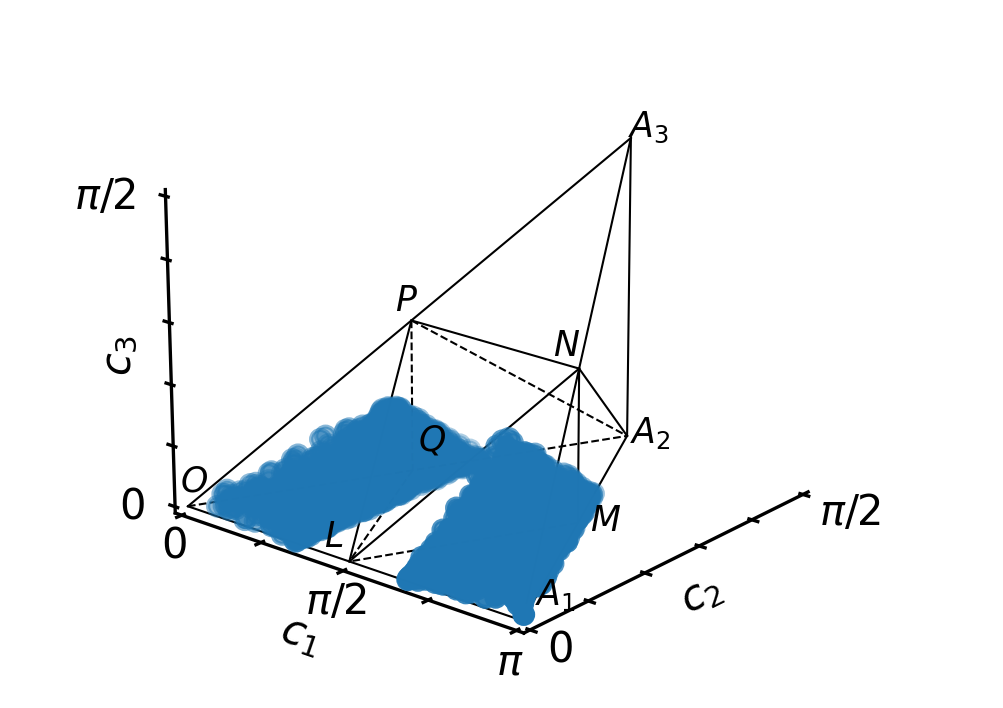

In [13]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/3, length=2)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

volume inside points is:  0.025464319117115095


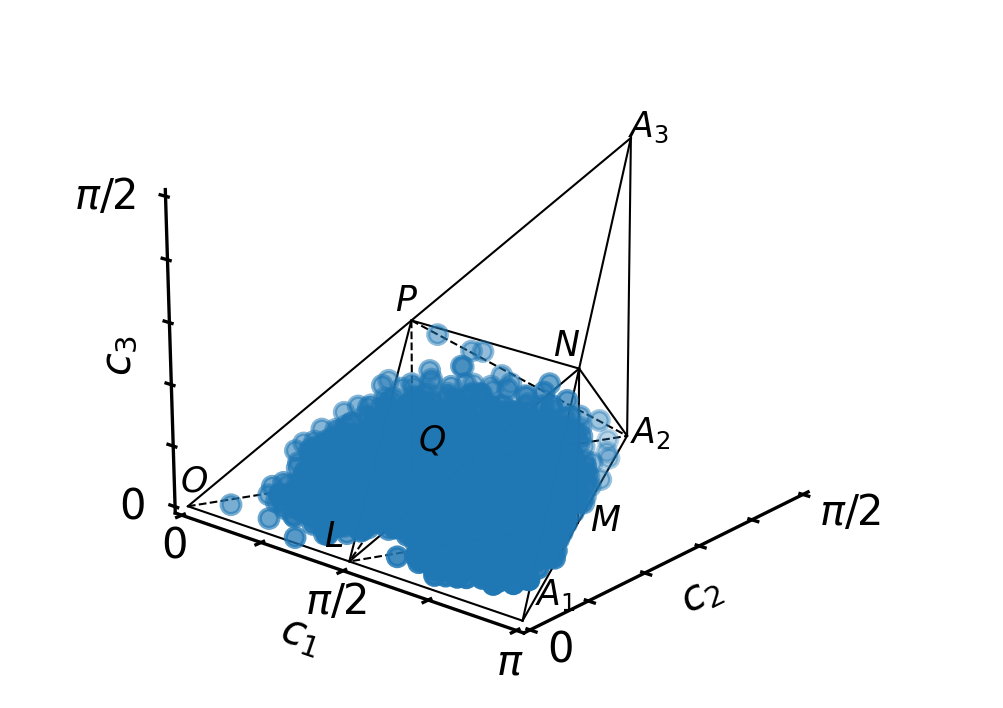

In [14]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/3, length=3)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

volume inside points is:  0.030122128404601517


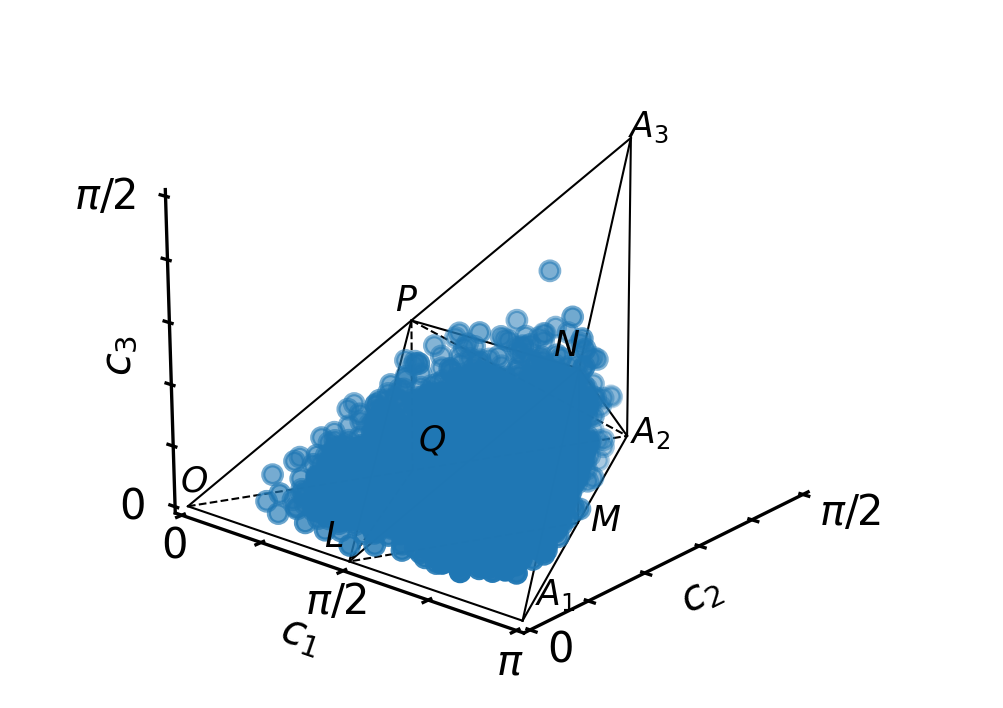

In [17]:
from weylchamber import WeylChamber
w = WeylChamber()
list_coordinates = sample(param=1/3, length=5)
w.plot()
#print(list_coordinates)

import scipy.spatial as ss
import numpy as np
hull = ss.ConvexHull(list_coordinates)
print('volume inside points is: ',hull.volume)

In [18]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [19]:
from custom_gates import *
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from itertools import cycle
from weylchamber import c1c2c3
from qiskit.circuit.library.standard_gates import *
from qiskit.quantum_info import Operator, random_unitary, random_clifford
import scipy.optimize as opt
import hashlib

In [26]:
class TemplateOptimizer:
    def __init__(
        self,
        template,
        objective_function_name="basic",
        unitary_sample_function="Haar",
        n_samples=1,
        template_iter_range=range(2, 4),
        thread_id=0,
        no_save=False,
    ):
        """Args:
        template: TemplateCircuit object
        objective_function_name: "nuop|basic" or "weyl"
        unitary_sample_function: "Haar" or "Clifford for random sampling, "SWAP", "CNOT", "iSWAP" for single gates
        n_samples: the number of times to sample a gate and minimize template on
        template_iter_range: a range() object that whos values are passed to template.build()
        """
        self.template = template
        self.sampler = self._sample_function(unitary_sample_function)
        self.n_samples = n_samples
        self.obj_f_name = objective_function_name
        self.template_iter_range = template_iter_range
        self.filekey = hashlib.sha1(
            (
                self.template.hash
                + str(objective_function_name)
                + str(unitary_sample_function)
                + str(template_iter_range)
            ).encode()
        ).hexdigest()
        self.plot_title = None
        self.training_loss = []
        self.training_reps = []
        self.thread_id = thread_id
        self.no_save = True
        self.coordinate_list = []

    def run(self, override_saved=False):
        # first attempt to load n_samples from data
        offset = 0
        results = None
        if False and not override_saved and not self.no_save:
            results = h5py_load(self.filekey, "training_loss", "training_reps")
            if results is not None:
                self.training_loss = pad_to_rag(results["training_loss"])
                self.training_reps = results["training_reps"].tolist()
                offset = len(self.training_loss)
                logging.info(f"Thread{self.thread_id}: Loaded {offset} samples")

        # run minimize on the remaining samples
        # use try finally, so if end early stills writes back what it has thus far
        # XXX I'm not sure this actually works, dont rely on it
        best_result, best_Xk, best_cycles = None, None, None
        try:
            for i in range(offset, self.n_samples):
                logging.info(f"Thread{self.thread_id}: Starting sample iter {i}")
                self.training_loss.append([])
                target_unitary = self.sampler()
                obj = self._objective_function(self.obj_f_name, target_unitary)
                best_result, best_Xk, best_cycles = self.minimize(
                    obj=obj, iter=i, t_range=self.template_iter_range
                )
        finally:
            # finally, save again
            if False and self.n_samples > offset and not self.no_save:
                # use list comprehension to pass by value (deepcopy)
                h5py_save(
                    self.filekey,
                    training_loss=rag_to_pad([row[:] for row in self.training_loss]),
                    training_reps=self.training_reps,
                )
        return best_result, best_Xk, best_cycles

    def minimize(self, obj, iter, t_range):
        # NOTE: potential for speedup?
        # you can calculate ahead of time the number of repetitions needed using traces??

        # callback used to save current loss after each iteration
        def callbackF(xk):
            # loss = obj(xk)
            # temp_training_loss.append(loss)
            gate = self.template.eval(xk)
            c1, c2, c3 = weylchamber.c1c2c3(gate)
            self.coordinate_list.append((c1,c2,c3))

        best_result = None
        best_Xk = None
        best_cycles = -1

        # each t creates fresh template with new repetition param
        for t in t_range:
            logging.info(f"Thread{self.thread_id}: Starting cycle length {t}")
            temp_training_loss = []
            self.template.build(n_repetitions=t)

            result = opt.minimize(
                fun=obj,
                x0=self.template.initial_guess(),
                callback=callbackF, #None if self.no_save else callbackF,
                options={"maxiter": 200},
            )

            # result is good, update temp vars
            if best_result is None or result.fun < best_result:
                best_result = result.fun
                best_Xk = result.x
                best_cycles = self.template.cycles
                self.training_loss[iter] = temp_training_loss

            # already good enough, save time by stopping here
            if best_result < 1e-9:
                logging.info(f"Thread{self.thread_id}: Break on cycle {t}")
                break

        logging.info(f"Thread{self.thread_id}: loss= {best_result}")
        self.training_reps.append(best_cycles)
        return best_result, best_Xk, best_cycles

    def _sample_function(self, name):
        if name == "CParitySwap":
            return lambda: CParitySwap()
        if name == "CiSWAP":
            return lambda: np.array(
                [
                    [1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 0, 1j, 0],
                    [0, 0, 0, 0, 0, 1j, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1],
                ]
            )
        if name == "CCiX":
            return lambda: np.array(
                [
                    [1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0, 0, 0],
                    [0, 0, 0, 1, 0, 0, 0, 0],
                    [0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 0, 0, 0, 1j],
                    [0, 0, 0, 0, 0, 0, 1j, 0],
                ]
            )
        if name == "Peres":
            return lambda: Peres()
        if name == "Toffoli":
            return lambda: CCXGate()
        if name == "CSWAP":
            return lambda: CSwapGate()
        if name == "RCCXGate":
            return lambda: RCCXGate()
        if name == "SWAP":
            return lambda: SwapGate()
        if name == "CNOT":
            return lambda: CXGate()
        if name == "iSWAP":
            return lambda: iSwapGate()
        if name == "Haar":
            return lambda: random_unitary(dims=2**self.template.n_qubits).data
        if name == "Clifford":
            return lambda: Operator(
                random_clifford(num_qubits=self.template.n_qubits)
            ).data
        else:
            raise ValueError(f"No sample function named {name}")

    def _objective_function(self, name, target):
        if name == "basic":
            return (
                lambda X: 1
                - np.abs(
                    np.trace(np.matmul(np.matrix(target).getH(), self.template.eval(X)))
                )
                / np.array(target).shape[0]
            )
        if name == "square":
            return lambda X: 1 - (
                np.abs(np.trace(np.matmul(np.matrix(target).getH(), self.template.eval(X)))) ** 2
                + np.array(target).shape[0]
            ) / (np.array(target).shape[0] * (np.array(target).shape[0] + 1))

    @staticmethod
    def plot(fig_title, *optimizers):
        c = ["black", "tab:red", "tab:blue", "tab:orange", "tab:green"]

        # each optimizer is its own column subplot
        fig, axs = plt.subplots(1, len(optimizers), sharey=True, squeeze=False)
        for ax_index, optimizer in enumerate(optimizers):

            # each sample gets plotted as a faint line
            for i in range(optimizer.n_samples):
                axs[0][ax_index].plot(
                    optimizer.training_loss[i],
                    alpha=0.2,
                    color=c[optimizer.training_reps[i] % len(c)],
                    linestyle="-",
                )

            # plot horizontal line to show average of final converged value
            converged_averaged = np.mean([el[-1] for el in optimizer.training_loss])
            axs[0][ax_index].axhline(
                converged_averaged, alpha=0.8, color="tab:gray", linestyle="--"
            )
            axs[0][ax_index].text(
                0.5,
                converged_averaged * 1.01,
                "Avg: " + "{:.2E}".format(converged_averaged),
                {"size": 5},
            )

            # custom average for ragged array
            # XXX there must be a smart way to do this I couldn't think of it at the time I wrote this :(
            for reps in set(optimizer.training_reps):
                # filter training data for each rep value
                temp = [
                    optimizer.training_loss[i]
                    for i in range(len(optimizer.training_reps))
                    if optimizer.training_reps[i] == reps
                ]

                # construct average over points where data exists
                # uses row-col outer-inner loop over points, increments counter k for norming
                temp_average = []
                for i in range(max([len(el) for el in temp])):
                    temp_average.append(0)
                    k = 0
                    for j in range(len(temp)):
                        if i < len(temp[j]):
                            temp_average[i] += temp[j][i]
                            k += 1
                    temp_average[i] /= k

                # plot average with full color
                axs[0][ax_index].plot(
                    temp_average,
                    color=c[reps % len(c)],
                    label=f"L{reps}",
                    linestyle="-",
                )

            axs[0][ax_index].set_yscale("log")
            axs[0][ax_index].set_xlabel("Training Steps")
            axs[0][ax_index].set_title(f"{optimizer.plot_title}")
            axs[0][ax_index].legend()

        fig.suptitle(f"{fig_title}, (N={optimizers[0].n_samples})", y=0.92)
        axs[0][0].set_ylabel("Training Loss")
        fig.tight_layout()
        fig.show()


INFO:root:Thread0: Starting sample iter 0
INFO:root:Thread0: Starting cycle length 3
INFO:root:Thread0: loss= 0.15000000007239578


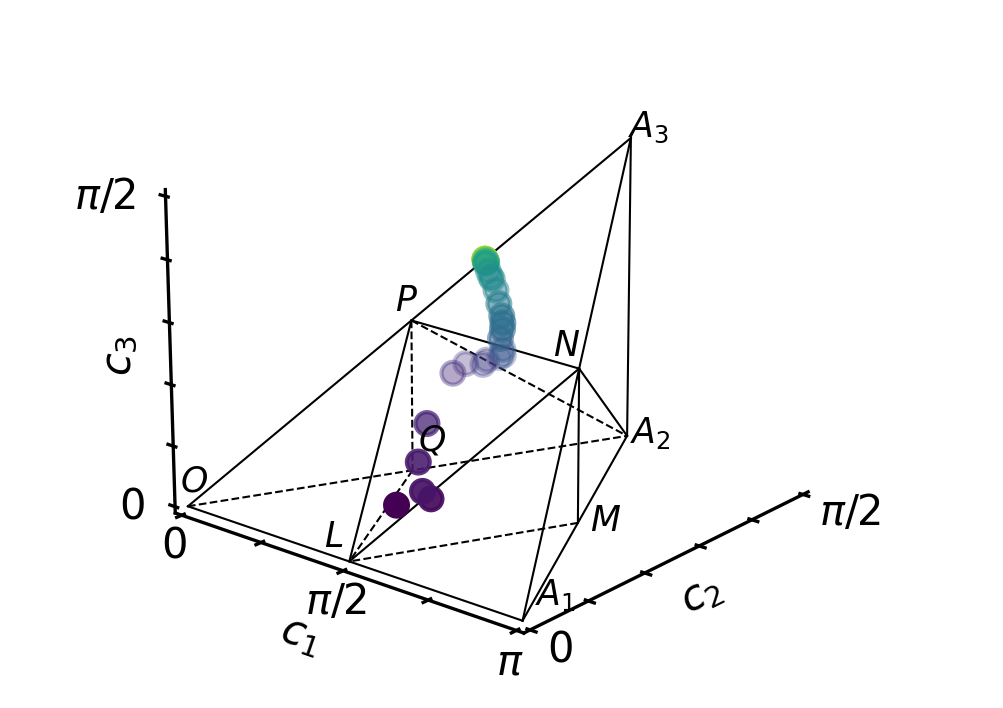

In [53]:
N = 1
template = TemplateCircuit(gate_2q_params=[1/3])
optimizer = TemplateOptimizer(template, n_samples=N, objective_function_name="square",unitary_sample_function="SWAP", template_iter_range=range(3,4))
optimizer.run()

col = np.arange(len(optimizer.coordinate_list))
w = WeylChamber();
w.scatter(*zip(*optimizer.coordinate_list), s=30, c=col, marker='o')
w.plot()
